# Finite-size sharpening of a synchrony transition
This is an appendix-only Kuramoto mean-field analogue.



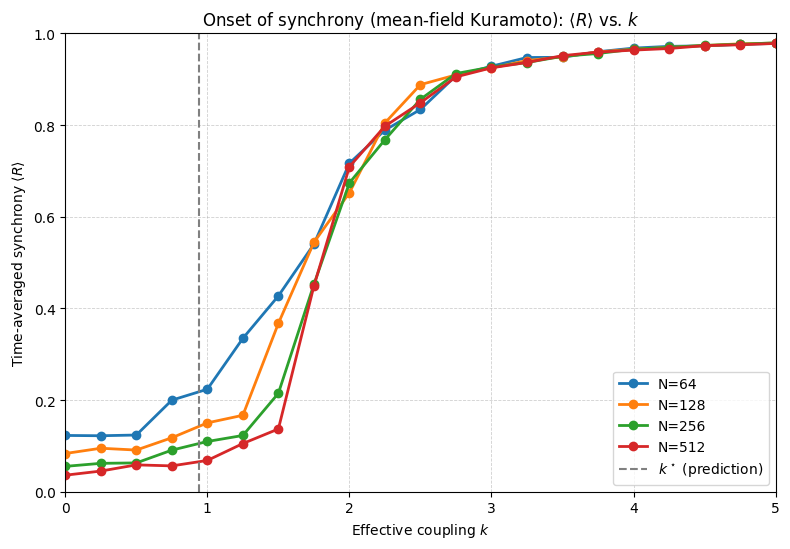

% Note: table uses booktabs (\toprule/\midrule/\bottomrule).
\begin{table}[]
\centering
\caption{Time–averaged synchrony $\langle R\rangle$ as a function of effective coupling $k$
for several network sizes $N$. Values are extracted from the simulations shown in Fig.~\ref{fig:R_vs_k}.}
\label{tab:R_vs_k}
\begin{tabular}{ccc}
\toprule
$N$ & $k$ & $\langle R\rangle$ \\
\midrule
64  & 0.0 & 0.123 \\
64  & 1.0 & 0.224 \\
64  & 2.0 & 0.717 \\
128  & 0.0 & 0.083 \\
128  & 1.0 & 0.150 \\
128  & 2.0 & 0.652 \\
256  & 0.0 & 0.055 \\
256  & 1.0 & 0.110 \\
256  & 2.0 & 0.674 \\
\bottomrule
\end{tabular}
\end{table}
Saved LaTeX table: outputs/kuramoto_synchrony_appendix/R_vs_k_table.tex

Saved figure: R_vs_k_meanfield.png


In [ ]:
# Finite-size sharpening of the synchrony transition


import os
from pathlib import Path
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt

SEED_BASE = 42

OUTDIR = Path("outputs") / "kuramoto_synchrony_appendix"
OUTDIR.mkdir(parents=True, exist_ok=True)
SAVE_FIGS = True

N_REPS = 5
PLOT_BAND = False

# k* handling: keep legacy default, but allow theory or external override.
K_STAR_MODE = 'fixed'  # 'fixed' (legacy), 'theory', or 'from_json' came from 03_spectral_verification_gershgorin.ipynb
K_STAR_FIXED = 0.94
K_STAR_JSON_DEFAULT = str(Path('outputs') / 'nos_panels' / 'k_star.json')
K_STAR_JSON = K_STAR_JSON_DEFAULT

def _find_k_star_json(start: Path) -> Optional[Path]:
    """Search upwards for a k_star.json file.

    We check (in order):
      1) outputs/nos_panels/k_star.json
      2) outputs/kuramoto_synchrony_appendix/k_star.json
      3) outputs/k_star.json

    Returns a Path if found, otherwise None.
    """
    cur = start.resolve()
    for _ in range(6):
        cands = [
            cur / 'outputs' / 'nos_panels' / 'k_star.json',
            cur / 'outputs' / 'kuramoto_synchrony_appendix' / 'k_star.json',
            cur / 'outputs' / 'k_star.json',
        ]
        for cand in cands:
            if cand.exists():
                return cand
        cur = cur.parent
    return None

# If the default path does not exist, attempt to locate it relative to CWD.
_auto = _find_k_star_json(Path.cwd())
if _auto is not None:
    K_STAR_JSON = str(_auto)


def _make_rng(N, k, rep, seed_base=SEED_BASE):
    # Deterministic per (N,k,rep) RNG for reproducibility.
    # Use a stable integer mapping; avoid Python hash randomisation.
    key = int(seed_base + 1000003*N + 10007*rep + int(round(1000*k)))
    return np.random.default_rng(key)


# --- Kuramoto simulator (all-to-all mean-field) --
def simulate_kuramoto_meanfield(N, K, T=20.0, dt=0.01, t_burn=5.0, sigma_omega=1.0, rng=None):
    """
    N: number of oscillators
    K: coupling strength (effective coupling k)
    T: total integration time
    dt: timestep
    t_burn: initial transient to discard
    sigma_omega: std of natural frequencies (Gaussian)
    Returns time-average of the order parameter <R> over [t_burn, T].
    """
    steps = int(T / dt)
    burn  = int(t_burn / dt)
    if rng is None:
        rng = np.random.default_rng(SEED_BASE)

    # Natural frequencies
    omega = rng.normal(0.0, sigma_omega, size=N)
    # Initial phases
    theta = rng.uniform(0, 2*np.pi, size=N)

    R_accum = 0.0
    count   = 0

    for t in range(steps):
        # Complex order parameter
        z = np.exp(1j*theta).mean()
        R = np.abs(z)

        # Kuramoto update (Euler)
        # dtheta_i = omega_i + K * R * sin(psi - theta_i), where z = R e^{i psi}
        psi = np.angle(z)
        theta += dt*(omega + K*R*np.sin(psi - theta))

        # Wrap phases
        theta %= 2*np.pi

        if t >= burn:
            R_accum += R
            count   += 1

    return R_accum / max(count, 1)

# --- Sweep over N and k ---
sigma_omega = 1.0
N_list  = [64, 128, 256, 512]
k_vals  = np.linspace(0.0, 5.0, 21)  # effective coupling grid
T, dt   = 25.0, 0.01                 # slightly longer to smooth curves
t_burn  = 7.5

# Optional: vertical marker k* (analogy only).
def _kuramoto_kc_gaussian(sigma):
    # Mean-field Kuramoto critical coupling for a symmetric unimodal g(omega): Kc = 2/(pi g(0)).
    # For Gaussian N(0, sigma^2), g(0)=1/(sqrt(2*pi)*sigma).
    g0 = 1.0 / (np.sqrt(2.0*np.pi) * sigma)
    return 2.0 / (np.pi * g0)

k_star = K_STAR_FIXED
if K_STAR_MODE == 'theory':
    k_star = float(_kuramoto_kc_gaussian(sigma_omega))
elif K_STAR_MODE == 'from_json':
    try:
        import json
        with open(K_STAR_JSON, 'r') as f:
            k_star = float(json.load(f).get('k_star'))
    except Exception:
        k_star = K_STAR_FIXED

R_curves = {}
R_stds   = {}
for N in N_list:
    R_curve = []
    R_std_curve = []
    for k in k_vals:
        reps = [simulate_kuramoto_meanfield(N, k, T=T, dt=dt, t_burn=t_burn, sigma_omega=sigma_omega, rng=_make_rng(N, k, rep)) for rep in range(N_REPS)]
        R_curve.append(float(np.mean(reps)))
        R_std_curve.append(float(np.std(reps, ddof=1)) if N_REPS > 1 else 0.0)
    R_curves[N] = np.array(R_curve)
    R_stds[N]   = np.array(R_std_curve)

# --- Plot ---
plt.figure(figsize=(8, 5.6))
for N in N_list:
    plt.plot(k_vals, R_curves[N], marker='o', linewidth=2.0, label=f'N={N}')
    if PLOT_BAND and N_REPS > 1:
        lo = np.clip(R_curves[N] - R_stds[N], 0.0, 1.0)
        hi = np.clip(R_curves[N] + R_stds[N], 0.0, 1.0)
        plt.fill_between(k_vals, lo, hi, alpha=0.15)

plt.axvline(k_star, linestyle='--', linewidth=1.5, color='gray', label=r'$k^\star$ (prediction)')
plt.xlabel('Effective coupling $k$')
plt.ylabel(r'Time-averaged synchrony $\langle R\rangle$')
plt.title(r'Onset of synchrony (mean-field Kuramoto): $\langle R\rangle$ vs. $k$')
plt.ylim(0, 1.0)
plt.xlim(k_vals[0], k_vals[-1])
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig(str(OUTDIR / 'R_vs_k_meanfield.png'), dpi=220)
plt.show()

# --- Produce a compact  table  ---
rep_k_targets = [0.0, 1.0, 2.0]

# helper to pick nearest grid point
def nearest_index(arr, value):
    return int(np.argmin(np.abs(arr - value)))

rows = []
for N in [64, 128, 256]:
    for k0 in rep_k_targets:
        idx = nearest_index(k_vals, k0)
        rows.append((N, k_vals[idx], R_curves[N][idx]))

# Print table
print('% Note: table uses booktabs (\\toprule/\\midrule/\\bottomrule).')
print(r"""\begin{table}[]
\centering
\caption{Time–averaged synchrony $\langle R\rangle$ as a function of effective coupling $k$
for several network sizes $N$. Values are extracted from the simulations shown in Fig.~\ref{fig:R_vs_k}.}
\label{tab:R_vs_k}
\begin{tabular}{ccc}
\toprule
$N$ & $k$ & $\langle R\rangle$ \\
\midrule""")

for N, k0, Rbar in rows:
    print(f"{N}  & {k0:.1f} & {Rbar:.3f} \\\\")

print(r"""\bottomrule
\end{tabular}
\end{table}""")

try:
    table_path = OUTDIR / "R_vs_k_table.tex"
    with open(table_path, "w", encoding="utf-8") as f:
        # Re-run the same prints into a file buffer.
        f.write("% Note: table uses booktabs (\\toprule/\\midrule/\\bottomrule).\n")
        f.write("\\begin{table}[]\n\\centering\n")
        f.write("\\caption{Time--averaged synchrony $\\langle R\\rangle$ as a function of effective coupling $k$\n")
        f.write("for several network sizes $N$. Values are extracted from the simulations shown in Fig.~\\ref{fig:R_vs_k}.}\n")
        f.write("\\label{tab:R_vs_k}\n\\begin{tabular}{ccc}\n\\toprule\n")
        f.write("$N$ & $k$ & $\\langle R\\rangle$ \\\\ \n\\midrule\n")
        for N, k0, Rbar in rows:
            f.write(f"{N}  & {k0:.1f} & {Rbar:.3f} \\\\ \n")
        f.write("\\bottomrule\n\\end{tabular}\n\\end{table}\n")
    print(f"Saved LaTeX table: {table_path.as_posix()}")
except Exception as _e:
    print(f"[warn] Could not write LaTeX table to file: {_e}")
print("\nSaved figure: R_vs_k_meanfield.png")